In [1]:
from scripts import preprocess
from scripts import utils
from scripts import models
import pandas as pd
import gc
import argparse

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pandas.tseries.holiday import USFederalHolidayCalendar
from sklearn.decomposition import PCA
import statsmodels.api as sm

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import warnings
warnings.simplefilter("ignore")

In [2]:

def prepare_data(df, weather_data, time_slot):
    data = pd.DataFrame()

    start = df["Timestamp"].min().replace(hour=0, minute=0, second=0)
    end = df["Timestamp"].max().replace(hour=23, minute=59)
    index = pd.date_range(start=start, end=end, freq=str(time_slot) + 'Min', normalize=True)

    station_groups = df.groupby("Station_ID")
    for sid, sdf in station_groups:
        sdf = utils.aggregate_by_time_slot(sdf, time_slot, index)
        sdf = utils.fill_weather_data(sdf, weather_data)
        sdf["Station_ID"] = sid
        data = data.append(sdf)

    cloudy_conds = ["Clear", "Partly Cloudy", "Scattered Clouds", "Mostly Cloudy", "Haze", "Overcast"]
    data.loc[-data.Condition.isin(cloudy_conds), 'Condition'] = 0
    data.loc[data.Condition.isin(cloudy_conds), 'Condition'] = 1
    data.rename(index=str, columns={"Condition": "Condition_Good"}, inplace=True)
    data.index = pd.to_datetime(data.index)

    data['Time_Fragment'] = np.ceil((data.index.hour*60 + data.index.minute)/time_slot)

    cal = USFederalHolidayCalendar()
    holidays = cal.holidays(start=data.index.min(), end=data.index.max())
    data['Holiday'] = 0
    data.loc[data.index.normalize().isin(holidays), 'Holiday'] = 1

    data['Weekday'] = data.index.dayofweek
    data['Month'] = data.index.month

    data['Weekend'] = 0
    data.loc[data['Weekday'] > 4, 'Weekend'] = 1

    data.loc[data['Weekday'] == 5, 'Weekday'] += 1
    data.loc[data['Weekday'] == 6, 'Weekday'] += 2

    data['Weekday_Cos'] = np.cos(2*np.pi/10 * (data['Weekday']-2))
    data['Weekday_Sin'] = np.sin(2*np.pi/10 * (data['Weekday']-2))
    data['Month_Cos'] = np.cos(2*np.pi/12 * (data['Month']))
    data['Month_Sin'] = np.sin(2 * np.pi / 12 * (data['Month']))
    data['Time_Fragment_Cos'] = np.cos(2*np.pi/(data['Time_Fragment'].max()+1) * (data['Time_Fragment']))
    data['Time_Fragment_Sin'] = np.sin(2 * np.pi / (data['Time_Fragment'].max() + 1) * (data['Time_Fragment']))

    data.drop(['Weekday', 'Month', 'Time_Fragment'], axis='columns', inplace=True)

    data['Holiday'] = data['Holiday'].astype(np.int8)
    data['Condition_Good'] = data['Condition_Good'].astype(np.int8)
    data['Station_ID'] = data['Station_ID'].astype(np.int16)
    data['Weekend'] = data['Weekend'].astype(np.int8)
    data['Weekday_Cos'] = data['Weekday_Cos'].astype(np.float16)
    data['Month_Cos'] = data['Month_Cos'].astype(np.float16)
    data['Time_Fragment_Cos'] = data['Time_Fragment_Cos'].astype(np.float16)
    data['Time_Fragment_Sin'] = data['Time_Fragment_Sin'].astype(np.float16)
    data['Weekday_Sin'] = data['Weekday_Sin'].astype(np.float16)
    data['Month_Sin'] = data['Month_Sin'].astype(np.float16)

    max_count = data['Count'].max()
    if max_count < (1 << 7):
        data['Count'] = data['Count'].astype(np.int8)
    elif max_count < (1 << 15):
        data['Count'] = data['Count'].astype(np.int16)
    elif max_count < (1 << 31):
        data['Count'] = data['Count'].astype(np.int32)
    data.info()

    return data

In [4]:
weather_data_path = "cleaned_data/weather.csv"
trip_data_path = "cleaned_data/JC_trip_data.csv"
time_slot = 60
test_pct = 0.2
start = pd.to_datetime("2018-06-01").normalize()
seasonality = 1440//time_slot if 1440//time_slot > 1 else 7
ot = 720

In [5]:
weather_data = utils.read_cleaned_weather_data(weather_data_path)
assert weather_data is not None

trip_data = utils.read_cleaned_trip_data(trip_data_path)
assert trip_data is not None

assert 24*60 % time_slot == 0

trip_data = trip_data[trip_data['Start_Time'] >= start]
preprocess.remove_trip_outlier(trip_data, ot)

Loading trip data:   0%|          | 0/1 [00:00<?, ?file/s]

32759 rows from cleaned_data/weather.csv have been read
Columns: ['Condition', 'Datetime', 'Humidity', 'Temperature', 'Visibility', 'Wind']


606959 rows from cleaned_data/JC_trip_data.csv have been read
Columns: ['End_Latitude', 'End_Longitude', 'End_Station_ID', 'Start_Holiday', 'Start_Hour', 'Start_Latitude', 'Start_Longitude', 'Start_Month', 'Start_Season', 'Start_Station_ID', 'Start_Time', 'Start_Weekday', 'Start_Year', 'Stop_Holiday', 'Stop_Hour', 'Stop_Month', 'Stop_Season', 'Stop_Time', 'Stop_Weekday', 'Stop_Year', 'Trip_Duration']


In [6]:
start_stations_ids = list(utils.get_start_station_dict(trip_data).keys())
trip_data = trip_data[trip_data.End_Station_ID.isin(start_stations_ids)]
pick_ups = trip_data[['Start_Station_ID', 'Start_Time']].copy()

In [7]:
del trip_data
gc.collect()

35

In [8]:
pick_ups.rename(columns={"Start_Station_ID": "Station_ID", "Start_Time": "Timestamp"}, inplace=True)
th_day = pick_ups['Timestamp'].max().value - (pick_ups['Timestamp'].max().value - pick_ups['Timestamp'].min().value) * test_pct
th_day = pd.to_datetime(th_day).normalize()

data = prepare_data(pick_ups, weather_data, time_slot)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 255650 entries, 2018-06-01 00:00:00 to 2018-12-31 00:00:00
Data columns (total 15 columns):
Count                255650 non-null int8
Temperature          255650 non-null float16
Wind                 255650 non-null float16
Humidity             255650 non-null int8
Visibility           255650 non-null float16
Condition_Good       255650 non-null int8
Station_ID           255650 non-null int16
Holiday              255650 non-null int8
Weekend              255650 non-null int8
Weekday_Cos          255650 non-null float16
Weekday_Sin          255650 non-null float16
Month_Cos            255650 non-null float16
Month_Sin            255650 non-null float16
Time_Fragment_Cos    255650 non-null float16
Time_Fragment_Sin    255650 non-null float16
dtypes: float16(9), int16(1), int8(5)
memory usage: 8.0 MB


In [9]:
station_freq_counts = pick_ups["Station_ID"].value_counts()
busiest_station = station_freq_counts.idxmax()
idle_station = station_freq_counts.idxmin()
median_station = station_freq_counts.index[len(station_freq_counts)//2]

In [51]:
pca_data = data.loc[data["Station_ID"]==busiest_station]

In [52]:
x_train = data[data.index < th_day]
x_test = data[data.index >= th_day]
y_train = x_train['Count']
y_test = x_test['Count']
x_train.drop('Count', axis=1, inplace=True)
x_test.drop('Count', axis=1, inplace=True)

In [53]:
x_train = pca_data[pca_data.index < th_day]
x_test = pca_data[pca_data.index >= th_day]
y_train = x_train['Count']
y_test = x_test['Count']
x_train.drop('Count', axis=1, inplace=True)
x_test.drop('Count', axis=1, inplace=True)

Creating SSA model


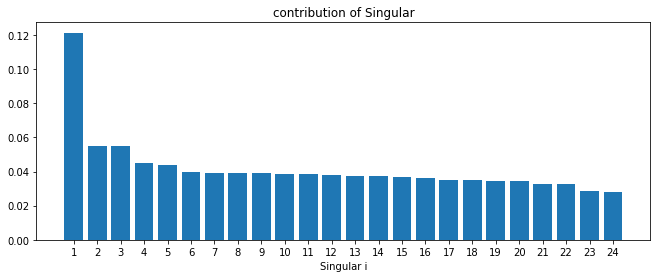

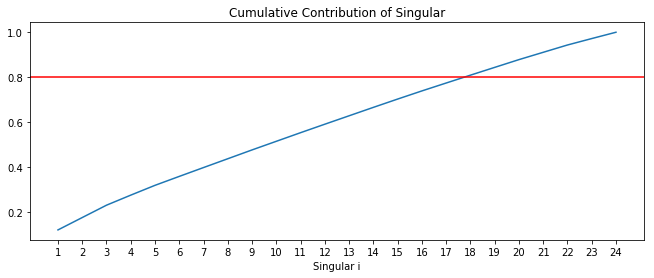

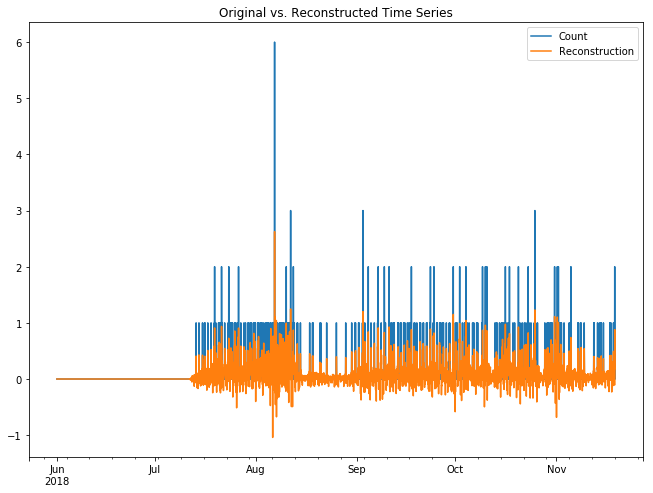

MAE: 0.22551070276776938   RMSE: 0.31200270625868387


(0.22551070276776938, 0.31200270625868387)

In [50]:
ssa = models.SSA()
ssa.test(x_train, y_train, seasonality, busiest_station)
ssa.fit(x_train, y_train, seasonality)
y = ssa.predict(x_test, 5)
models.score(y_test.tolist(), y)

MAE: 2.91187325777967   RMSE: 5.819965374566344


(2.91187325777967, 5.819965374566344)

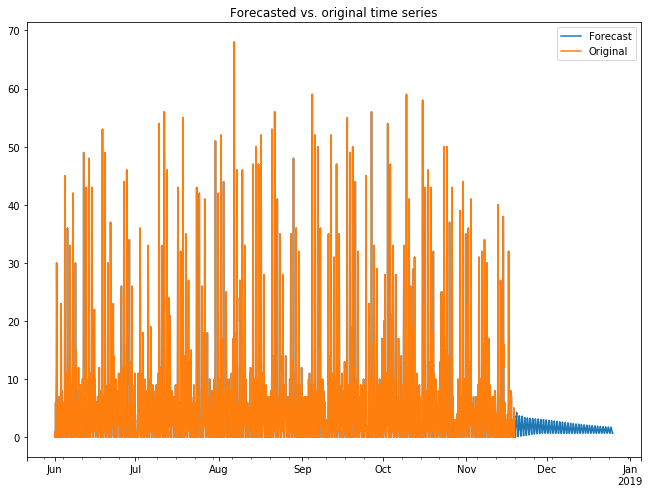

In [44]:
from scripts.mySSA import mySSA

# First enable display of graphs in the notebook
%matplotlib inline 
from matplotlib.pylab import rcParams

size = len(y_test)
signal_size = 6
s = 5

rcParams['figure.figsize'] = 11,8
myssa = mySSA(y_train)
myssa.embed(embedding_dimension=50, suspected_frequency=s)
myssa.decompose()
myssa.forecast_recurrent(steps_ahead=size, singular_values=list(range(signal_size)), plot=True)
ssa.fit(x_train, y_train, s)
y = ssa.predict(x_test, signal_size)
models.score(y_test.tolist(), y)


3  MAE: 2.9407428303141834   RMSE: 5.9393122446742055


4  MAE: 2.9407428303141834   RMSE: 5.9393122446742055


5  MAE: 2.8796841923334413   RMSE: 5.762872502848996


6  MAE: 2.9407428303141834   RMSE: 5.9393122446742055


Predicting:   0%|          | 0/1009 [00:00<?, ?row/s]

7  MAE: 2.888837080284449   RMSE: 5.796728029133098


8  MAE: 2.9407428303141834   RMSE: 5.9393122446742055


Predicting:   0%|          | 0/1009 [00:00<?, ?row/s]

9  MAE: 2.9199035964642075   RMSE: 5.967741334015718


10  MAE: 2.8796841923334413   RMSE: 5.762872502848996


Predicting:   0%|          | 0/1009 [00:00<?, ?row/s]

11  MAE: 2.851194504064246   RMSE: 5.878245683024981


12  MAE: 2.9407428303141834   RMSE: 5.9393122446742055


13  MAE: 2.890856174049095   RMSE: 5.83378310373814


14  MAE: 2.9121222718723283   RMSE: 5.893633212679435


15  MAE: 2.9199035964642075   RMSE: 5.967741334015718


16  MAE: 2.9407428303141834   RMSE: 5.9393122446742055


17  MAE: 3.0332536522876974   RMSE: 6.0071761982022895


18  MAE: 2.9540777650612258   RMSE: 5.913854765675198


19  MAE: 3.2199271457401792   RMSE: 5.8963888272514104


20  MAE: 2.8001445989831226   RMSE: 5.851742868263965


21  MAE: 2.9121222718723283   RMSE: 5.893633212679435


22  MAE: 2.851194504064246   RMSE: 5.878245683024981


Predicting:   0%|          | 0/1009 [00:00<?, ?row/s]

23  MAE: 2.990264170234435   RMSE: 6.046409639700753


24  MAE: 2.9407428303141834   RMSE: 5.9393122446742055


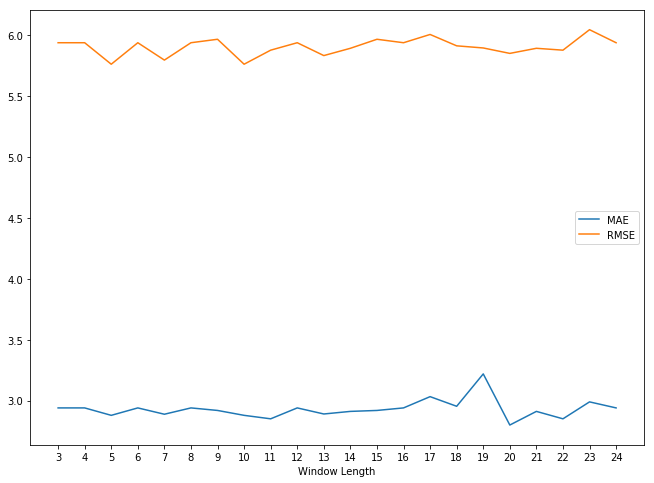

In [57]:
size = len(y_test)
signal_size = 5

maes = []
rmses = []

for i in range(3, 25):
    ssa.fit(x_train, y_train, i)
    y = ssa.predict(x_test, signal_size)
    print(i, end="  ")
    mae, rmse = models.score(y_test.tolist(), y)
    maes.append(mae)
    rmses.append(rmse)
    
plt.plot(range(3, 25), maes, label="MAE")
plt.plot(range(3,25), rmses, label="RMSE")
plt.xticks(range(3,25), range(3,25))
plt.xlabel("Window Length")
plt.legend()
plt.show()

MAE: 3.138323079814564   RMSE: 6.146204316450495


MAE: 3.139914612727497   RMSE: 6.1542227206918545


MAE: 2.9593521895633903   RMSE: 6.008280626506959


MAE: 2.9748728423937747   RMSE: 6.030116630152178


MAE: 2.9407428303141834   RMSE: 5.9393122446742055


MAE: 2.96079598418148   RMSE: 5.974751689847556


MAE: 2.9528444295713356   RMSE: 5.925683049965259


MAE: 2.986820214325358   RMSE: 5.992924540855979


MAE: 2.985306050999632   RMSE: 5.978360471420606


MAE: 2.9953812050210344   RMSE: 6.020319674007747


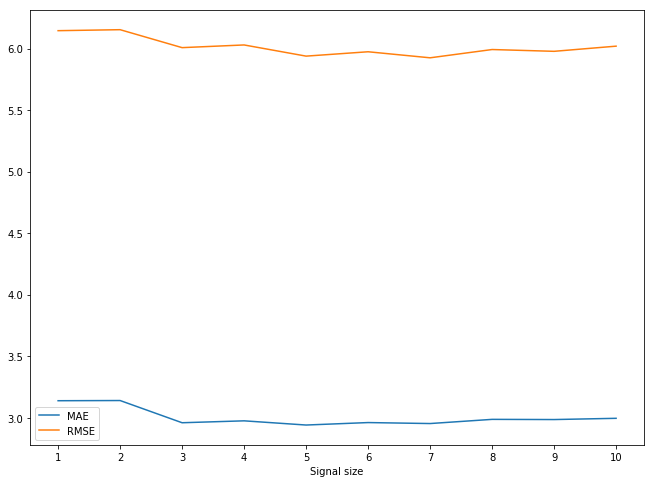

In [58]:
size = len(y_test)
s = 12

maes = []
rmses = []

for i in range(1, 11):
    ssa.fit(x_train, y_train, s)
    y = ssa.predict(x_test, i)
    mae, rmse = models.score(y_test.tolist(), y)
    maes.append(mae)
    rmses.append(rmse)
    
plt.plot(range(1,11), maes, label="MAE")
plt.plot(range(1,11), rmses, label="RMSE")
plt.xticks(range(1,11), range(1,11))
plt.xlabel("Signal size")
plt.legend()
plt.show()

Creating SSA model


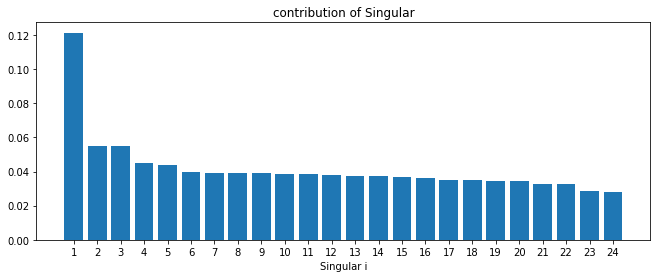

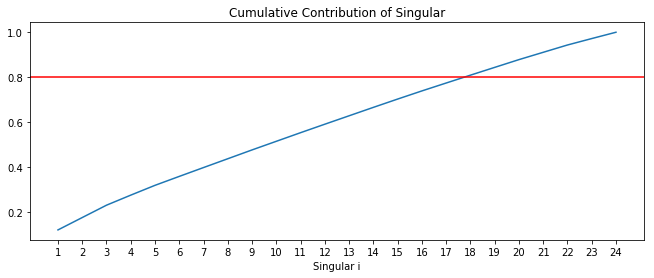

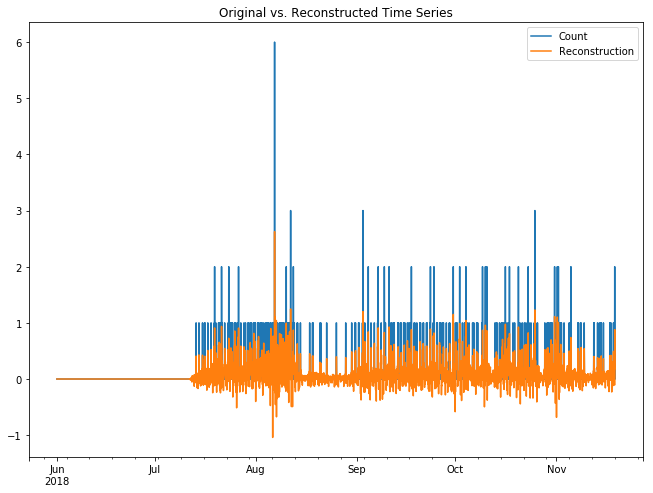

MAE: 0.22551070276776938   RMSE: 0.31200270625868387


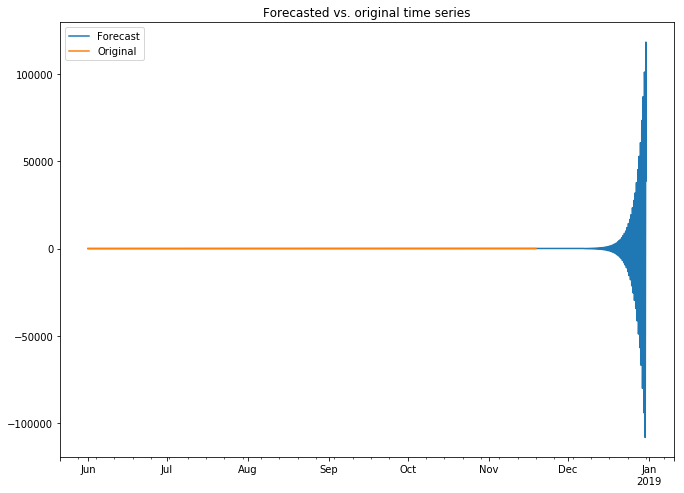

MAE: 5954.391337234669   RMSE: 17153.394044537737


Predicting:   0%|          | 0/1009 [00:00<?, ?row/s]

3  MAE: 0.22551070276776938   RMSE: 0.31200270625868387


Predicting:   0%|          | 0/1009 [00:00<?, ?row/s]

4  MAE: 0.22551070276776938   RMSE: 0.31200270625868387


5  MAE: 0.24037437857965177   RMSE: 0.3033695981531342


6  MAE: 0.22551070276776938   RMSE: 0.31200270625868387


  0%|          | 0/1 [00:00<?, ?group/s]

7  MAE: 0.4059965002758401   RMSE: 0.5140988546985231


8  MAE: 0.22551070276776938   RMSE: 0.31200270625868387


9  MAE: 0.23464008192906183   RMSE: 0.29919841450040774


10  MAE: 0.24037437857965177   RMSE: 0.3033695981531342


Predicting:   0%|          | 0/1009 [00:00<?, ?row/s]

11  MAE: 0.23324472007267355   RMSE: 0.2992099213816253


12  MAE: 0.22551070276776938   RMSE: 0.31200270625868387


13  MAE: 0.47871103976450824   RMSE: 0.5494822722134693


14  MAE: 0.3188386857704861   RMSE: 0.3599948966494838


15  MAE: 0.23464008192906183   RMSE: 0.29919841450040774


16  MAE: 0.22551070276776938   RMSE: 0.31200270625868387


17  MAE: 1.3943244649150084   RMSE: 2.126305884364565


18  MAE: 0.5883541902350033   RMSE: 0.7561395632092329


19  MAE: 0.40569065058991804   RMSE: 0.4811245817760212


20  MAE: 0.5799951282573522   RMSE: 0.7983947860878992


Predicting:   0%|          | 0/1009 [00:00<?, ?row/s]

21  MAE: 0.3188386857704861   RMSE: 0.3599948966494838


22  MAE: 0.23324472007267355   RMSE: 0.2992099213816253


23  MAE: 0.23807917292329767   RMSE: 0.30765622628241407


24  MAE: 0.22551070276776938   RMSE: 0.31200270625868387


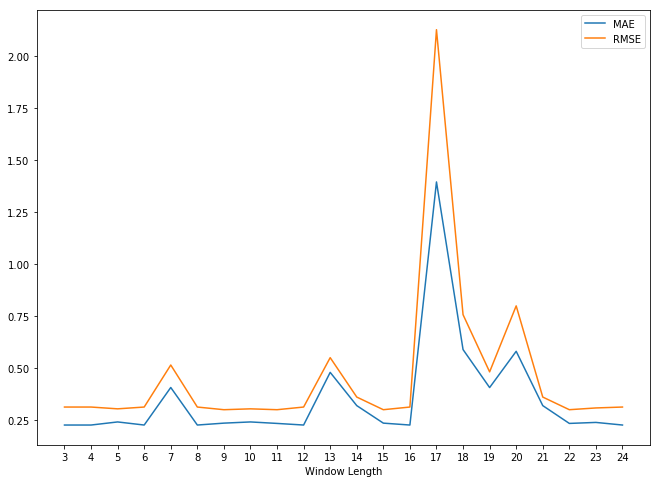

MAE: 0.19664620168794603   RMSE: 0.25847434296907534


MAE: 0.19461082725186743   RMSE: 0.25759101959467934


MAE: 0.1991090345899065   RMSE: 0.2648789647947942


MAE: 0.19798813745000887   RMSE: 0.26417141362739793


MAE: 0.22551070276776938   RMSE: 0.31200270625868387


MAE: 0.2209849233181626   RMSE: 0.3062992159603159


MAE: 0.5254898695611305   RMSE: 0.6858076112637773


MAE: 8545234.327904824   RMSE: 31237006.017630324


MAE: 2095531.3715399567   RMSE: 7328631.25575351


MAE: 711912.9603829705   RMSE: 2432189.415716592


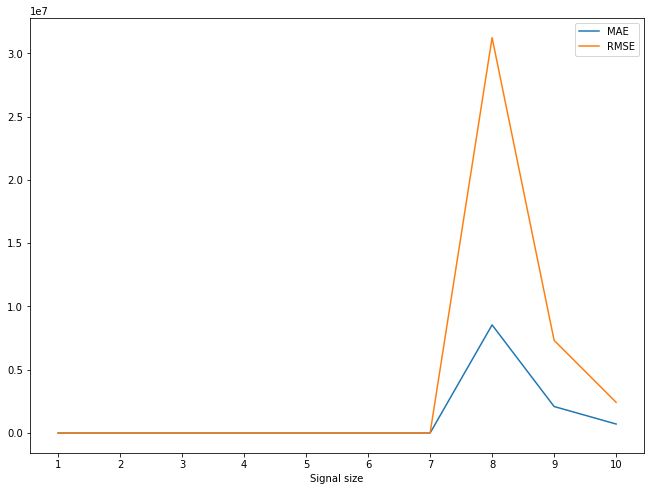

In [60]:
pca_data = data.loc[data["Station_ID"]==idle_station]
x_train = pca_data[pca_data.index < th_day]
x_test = pca_data[pca_data.index >= th_day]
y_train = x_train['Count']
y_test = x_test['Count']
x_train.drop('Count', axis=1, inplace=True)
x_test.drop('Count', axis=1, inplace=True)
ssa = models.SSA()
ssa.test(x_train, y_train, seasonality, idle_station)
ssa.fit(x_train, y_train, seasonality)
y = ssa.predict(x_test, 5)
models.score(y_test.tolist(), y)

size = len(y_test)
signal_size = 6
s = 5

rcParams['figure.figsize'] = 11,8
myssa = mySSA(y_train)
myssa.embed(embedding_dimension=50, suspected_frequency=s)
myssa.decompose()
myssa.forecast_recurrent(steps_ahead=size, singular_values=list(range(signal_size)), plot=True)
plt.show()
ssa.fit(x_train, y_train, s)
y = ssa.predict(x_test, signal_size)
models.score(y_test.tolist(), y)

size = len(y_test)
signal_size = 5

maes = []
rmses = []

for i in range(3, 25):
    ssa.fit(x_train, y_train, i)
    y = ssa.predict(x_test, signal_size)
    print(i, end="  ")
    mae, rmse = models.score(y_test.tolist(), y)
    maes.append(mae)
    rmses.append(rmse)
    
plt.plot(range(3, 25), maes, label="MAE")
plt.plot(range(3,25), rmses, label="RMSE")
plt.xticks(range(3,25), range(3,25))
plt.xlabel("Window Length")
plt.legend()
plt.show()



size = len(y_test)
s = 12

maes = []
rmses = []

for i in range(1, 11):
    ssa.fit(x_train, y_train, s)
    y = ssa.predict(x_test, i)
    mae, rmse = models.score(y_test.tolist(), y)
    maes.append(mae)
    rmses.append(rmse)
    
plt.plot(range(1,11), maes, label="MAE")
plt.plot(range(1,11), rmses, label="RMSE")
plt.xticks(range(1,11), range(1,11))
plt.xlabel("Signal size")
plt.legend()
plt.show()

Creating SSA model


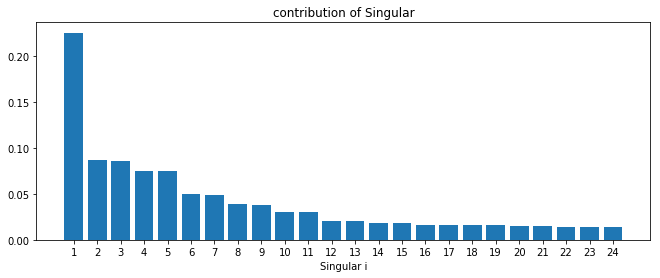

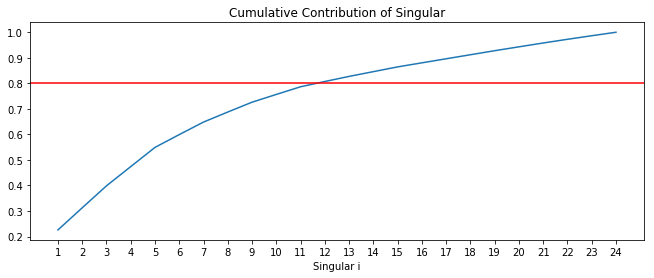

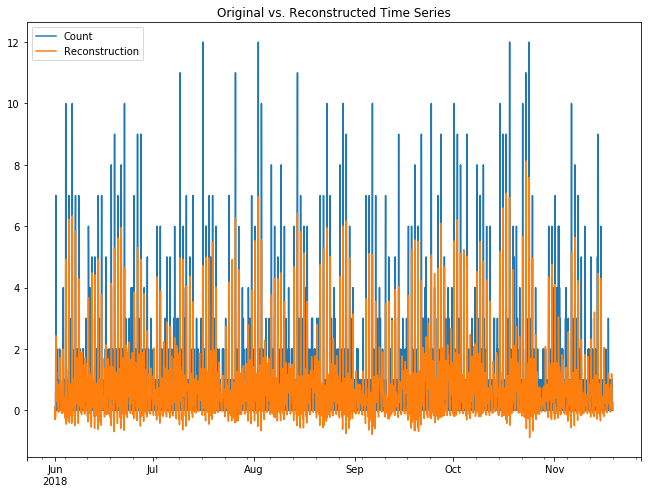

MAE: 0.6819001097512449   RMSE: 1.2470474809926575


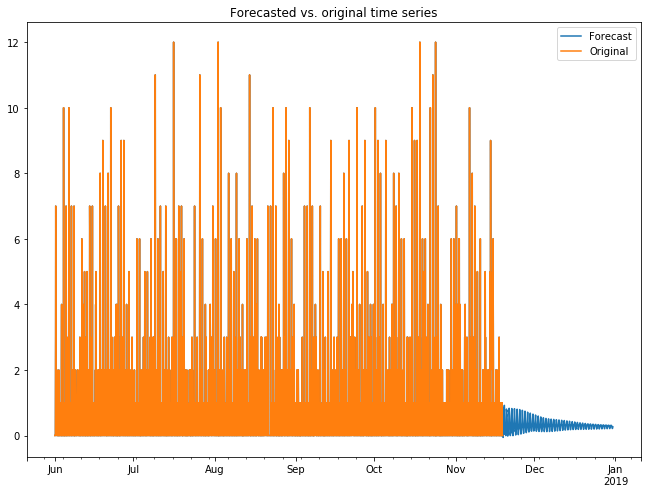

MAE: 0.6706478484103147   RMSE: 1.231594650775937


Predicting:   0%|          | 0/1009 [00:00<?, ?row/s]

3  MAE: 0.6819001097512449   RMSE: 1.2470474809926575


Predicting:   0%|          | 0/1009 [00:00<?, ?row/s]

4  MAE: 0.6819001097512449   RMSE: 1.2470474809926575


5  MAE: 0.6583017495229682   RMSE: 1.2119487040366421


6  MAE: 0.6819001097512449   RMSE: 1.2470474809926575


7  MAE: 0.6790819869618131   RMSE: 1.216744053753854


8  MAE: 0.6819001097512449   RMSE: 1.2470474809926575


9  MAE: 0.7019058416824707   RMSE: 1.2478797541633637


10  MAE: 0.6583017495229682   RMSE: 1.2119487040366421


11  MAE: 0.7577680978535513   RMSE: 1.240376913642942


12  MAE: 0.6819001097512449   RMSE: 1.2470474809926575


13  MAE: 0.8495369124285352   RMSE: 1.3538685982078837


14  MAE: 0.9505911180295104   RMSE: 1.3635195464182608


Predicting:   0%|          | 0/1009 [00:00<?, ?row/s]

15  MAE: 0.7019058416824707   RMSE: 1.2478797541633637


16  MAE: 0.6819001097512449   RMSE: 1.2470474809926575


17  MAE: 0.7536759652724939   RMSE: 1.2179719620686562


Predicting:   0%|          | 0/1009 [00:00<?, ?row/s]

18  MAE: 7.649880415869271   RMSE: 13.42282409646356


19  MAE: 1.302955555443682   RMSE: 1.7621681601064076


20  MAE: 0.9535217403639935   RMSE: 1.389786933423642


21  MAE: 0.9505911180295104   RMSE: 1.3635195464182608


22  MAE: 0.7577680978535513   RMSE: 1.240376913642942


Predicting:   0%|          | 0/1009 [00:00<?, ?row/s]

23  MAE: 0.6775942026672618   RMSE: 1.2634738637146032


24  MAE: 0.6819001097512449   RMSE: 1.2470474809926575


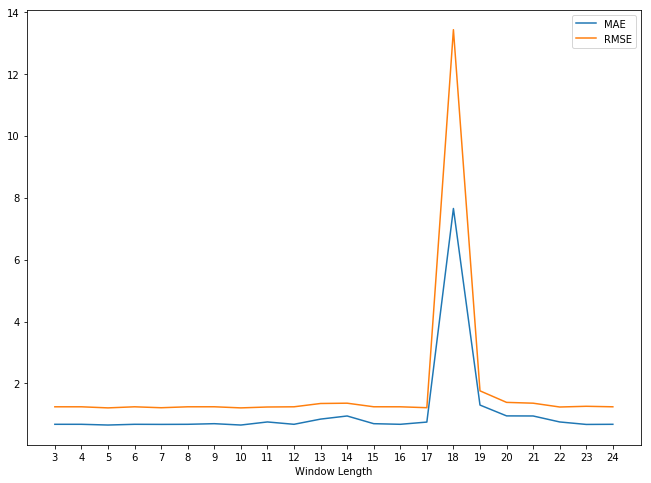

MAE: 0.7076816231212697   RMSE: 1.2635428525329433


MAE: 0.7082451936214496   RMSE: 1.2635895100521775


MAE: 0.718703549155186   RMSE: 1.2663358558774058


MAE: 0.7047842766892141   RMSE: 1.2607468689647023


MAE: 0.6819001097512449   RMSE: 1.2470474809926575


MAE: 0.6815111128759059   RMSE: 1.2497787441056154


MAE: 0.6775689706686935   RMSE: 1.2391526652873324


MAE: 0.6752668562594171   RMSE: 1.2414232961584566


MAE: 0.6793171127471781   RMSE: 1.2397890104712483


MAE: 0.6790761174296965   RMSE: 1.2419665504398447


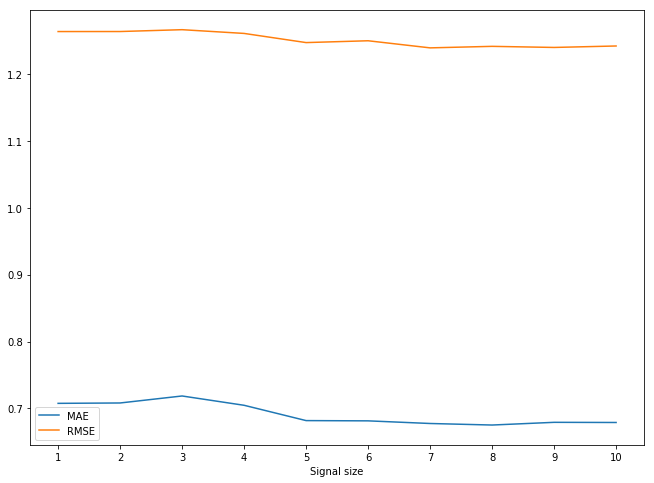

In [61]:
pca_data = data.loc[data["Station_ID"]==median_station]
x_train = pca_data[pca_data.index < th_day]
x_test = pca_data[pca_data.index >= th_day]
y_train = x_train['Count']
y_test = x_test['Count']
x_train.drop('Count', axis=1, inplace=True)
x_test.drop('Count', axis=1, inplace=True)
ssa = models.SSA()
ssa.test(x_train, y_train, seasonality, median_station)
ssa.fit(x_train, y_train, seasonality)
y = ssa.predict(x_test, 5)
models.score(y_test.tolist(), y)

size = len(y_test)
signal_size = 6
s = 5

rcParams['figure.figsize'] = 11,8
myssa = mySSA(y_train)
myssa.embed(embedding_dimension=50, suspected_frequency=s)
myssa.decompose()
myssa.forecast_recurrent(steps_ahead=size, singular_values=list(range(signal_size)), plot=True)
plt.show()
ssa.fit(x_train, y_train, s)
y = ssa.predict(x_test, signal_size)
models.score(y_test.tolist(), y)

size = len(y_test)
signal_size = 5

maes = []
rmses = []

for i in range(3, 25):
    ssa.fit(x_train, y_train, i)
    y = ssa.predict(x_test, signal_size)
    print(i, end="  ")
    mae, rmse = models.score(y_test.tolist(), y)
    maes.append(mae)
    rmses.append(rmse)
    
plt.plot(range(3, 25), maes, label="MAE")
plt.plot(range(3,25), rmses, label="RMSE")
plt.xticks(range(3,25), range(3,25))
plt.xlabel("Window Length")
plt.legend()
plt.show()



size = len(y_test)
s = 12

maes = []
rmses = []

for i in range(1, 11):
    ssa.fit(x_train, y_train, s)
    y = ssa.predict(x_test, i)
    mae, rmse = models.score(y_test.tolist(), y)
    maes.append(mae)
    rmses.append(rmse)
    
plt.plot(range(1,11), maes, label="MAE")
plt.plot(range(1,11), rmses, label="RMSE")
plt.xticks(range(1,11), range(1,11))
plt.xlabel("Signal size")
plt.legend()
plt.show()